# **Import the packages**

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout,Bidirectional, Input, concatenate
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import tensorflow as tf

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

import os.path
import wget
import shutil

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Canberk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Analysis and pre-processing**
*Assumption:* The file 'amazon_reviews.txt' need to be uploaded to google colab.
We use pandas to read the data. Our text file is 'tab' delimited. Hence we use *delimiter=\t* in the read_csv() of pandas. Some rows of the data has missing columns. We want to remove these columns during preprocessing. Hence we have the argument *error_bad_lines=False* which will make sure some of the rows with missing values will not be read. 

In [2]:
if not os.path.isfile('amazon_reviews.txt'):
    url = 'https://drive.google.com/uc?id=1-LYI_s6oZ0OTe3I0vFYRYIBVhjFswReY&export=download' # downloads db to train
    print('Downloading DB to train')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('amazon_reviews.zip')
    
dataset = pd.read_csv('amazon_reviews.txt', delimiter='\t', error_bad_lines=False)

Download Completed!
Unzipping...


**Analyse the data** <br/>
We use the head() of the pandas package to see what our data looks like. From this data we can see that 'LABEL' is the column we are trying to predict. To predict this value we make use of different features from the data. 
The different features we are using are 'RATING', 'REVIEW_TEXT' and 'VERIFIED_PURCHASE'.

In [3]:
dataset.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


We observe that the 'LABEL' and 'VERIFIED_PURCHASE' column are Categorical. To work with Deep learning models we need to convert these Categorical values to numerical values.

In [4]:
dataset['LABEL'] = pd.Categorical(dataset['LABEL'])
dataset['LABEL'] = dataset['LABEL'].cat.codes

In [5]:
dataset['VERIFIED_PURCHASE'] = pd.Categorical(dataset['VERIFIED_PURCHASE'])
dataset['VERIFIED_PURCHASE'] = dataset['VERIFIED_PURCHASE'].cat.codes

# **Train, validation and test split**
We have the data to work with and we need to split it to training set, validation set and test set. We train our model on the training set, tune our hyperparameters on the validation set and finally use it on the test set. We split the data into 80% training set, 10% validation set and 10% test set

In [6]:
x_train, x_testval, y_train, y_testval = train_test_split(dataset[['REVIEW_TEXT','RATING','VERIFIED_PURCHASE']], dataset[['LABEL']] , test_size = 0.20)
x_test, x_val, y_test, y_val = train_test_split(x_testval[['REVIEW_TEXT','RATING','VERIFIED_PURCHASE']], y_testval[['LABEL']] , test_size = 0.50)

In [7]:
x_train_review = x_train['REVIEW_TEXT']
x_train_verified_purchase = x_train['VERIFIED_PURCHASE']
x_train_rating = x_train['RATING']
x_val_review = x_val['REVIEW_TEXT']
x_val_verified_purchase = x_val['VERIFIED_PURCHASE']
x_val_rating = x_val['RATING']
x_test_review = x_test['REVIEW_TEXT']
x_test_verified_purchase = x_test['VERIFIED_PURCHASE']
x_test_rating = x_test['RATING']

# **Tokenize and Build vocabulary**
Once we have our training data we tokenize the 'REVIEW_TEXT' part of the training data and build a vocabulary from that. We have defined the vocabulary size to be 20000. Any token which is not part of the vocabulary will be repalced with \<unk>. We also set the max length to 100 which means that any sentence have a length greater than 100 will be truncated and any sentence having a length less than 100 will be padded.
We then convert the sequence of texts into sequence of integers 

In [8]:
vocab_size = 20000
oov_token = "<OOV>"
max_length = 100
padding_type = "post"
trunction_type="post"

In [9]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train_review)

In [10]:
X_train_sequences = tokenizer.texts_to_sequences(x_train_review)

In [11]:
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)

In [12]:
X_val_sequences = tokenizer.texts_to_sequences(x_val_review)
X_val_padded = pad_sequences(X_val_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)

In [13]:
X_test_sequences = tokenizer.texts_to_sequences(x_test_review)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)

# **Transfer Learning: Use pre-trained word embeddings**
In natural language processing, each word is represented as a dense vector. This kind of representation allows the model to understand what a word actually means. For this dense vector representation we use pre-trained GloVe embeddings.In our case we decided to represent each word with a 100-dimensional vector.

Below we download the GloVe embeddings, and create a embedding matrix from it.

In [14]:
if not os.path.isfile('glove.6B.100d.txt'):
    url = 'http://nlp.stanford.edu/data/glove.6B.zip' # large file, might take a while to download :)
    print('Downloading Pre-trained Word Embeddings')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('glove.6B.zip')

In [15]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Pre-trained Word Embeddings Loaded from Disk.\nFound %s word vectors.' % len(embeddings_index))

Pre-trained Word Embeddings Loaded from Disk.
Found 400000 word vectors.


In [16]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, max_length))
#print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        #print(embedding_vector.shape)
        embedding_matrix[i] = embedding_vector

In [17]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K

def recall_m(y_true, y_pred):
    print(y_true)
    print(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
# Enable GPU Training if available

tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Build the model**
The model that we have build has 3 heads. Each of the head will process 3 different features. The results of the 3 heads are concatenated and processed further in the feed forward network to get the final predictions. After a lot of experimentation on how to process these 3 features seperately we finalized this architecture. 



1.   First head is the **REVIEW_TEXT head**. This part of our model processes only the review text. We have a initial embedding layer which provides the embeddings for all the tokens in the training data. We process the sequence using a **Bi directional LSTM**. The output from bidirectional LSTM is fed to a dense Fully coonected layer
2.   Second head is the **RATING head** which is used to process the RATING feature in a dence fully connected layer.
3. Third head is the **VERIFIED_PURCHASE head** which will take as input the VERIFIED_PURCHASE feature and produce a intermediate represenataion for it.

The output from the 3 heads are concatenated and passed to a fully connected layer which does the predection. 
We use a 'Binary Cross Entropy' loss and all the 3 heads are trained jointly.





In [19]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            max_length,
                            embeddings_initializer=Constant(embedding_matrix),
                            #input_length=max_length,
                            trainable=False)

In [20]:
review_branch_ip = Input(shape=(100,), name='Review_input')
review_branch = embedding_layer(review_branch_ip)
review_branch = Dropout(0.2)(review_branch)
review_branch = Bidirectional(
    LSTM(64, dropout=0.2,recurrent_dropout=0)
)(review_branch)
review_branch = Dense(64,activation='relu')(review_branch)
review_branch_op = Dense(16, activation='relu')(review_branch)
#output = Dense(1,activation='sigmoid')(review_branch)


rating_branch_ip = Input(shape=(1,), name='Rating_input')
rating_branch = Dense(8,activation='relu')(rating_branch_ip)
rating_branch = Dropout(0.2)(rating_branch)
rating_branch_op = Dense(16,activation='relu')(rating_branch)



verified_purchase_branch_ip = Input(shape=(1,), name='Verified_Purchase_input')
verified_purchase_branch = Dense(8,activation='relu')(verified_purchase_branch_ip)
verified_purchase_branch = Dropout(0.2)(verified_purchase_branch)
verified_purchase_branch_op = Dense(16,activation='relu')(verified_purchase_branch)


concat = concatenate([review_branch_op, rating_branch_op, verified_purchase_branch_op], name='Concatenate')


final_op = Dense(8, activation='relu')(concat)
final_output = Dense(1,activation='sigmoid')(final_op)

model = Model(inputs=[review_branch_ip,rating_branch_ip,verified_purchase_branch_ip], outputs=final_output,
                    name='Final_output')

The model is compiled using the ADAM optimizer and Binary Cross Entropy loss

In [21]:
optimzer = Adam(clipvalue=0.5) # clip value to avoid the gradient exploding

model.compile(optimizer=optimzer, 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [22]:
model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Review_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     3267300     Review_input[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
Rating_input (InputLayer)       [(None, 1)]          0                                            
_______________________________________________________________________________________

In [23]:
history = model.fit([X_train_padded,x_train_rating,x_train_verified_purchase], y_train, batch_size=32,epochs=10, validation_data=([X_val_padded,x_val_rating,x_val_verified_purchase], y_val))

Epoch 1/10
525/525 [==============================] - 6s 12ms/step - loss: 0.5548 - acc: 0.7304 - val_loss: 0.4901 - val_acc: 0.7929
Epoch 2/10
525/525 [==============================] - 5s 10ms/step - loss: 0.4839 - acc: 0.7840 - val_loss: 0.4719 - val_acc: 0.7995
Epoch 3/10
525/525 [==============================] - 6s 11ms/step - loss: 0.4677 - acc: 0.7923 - val_loss: 0.4668 - val_acc: 0.8019
Epoch 4/10
525/525 [==============================] - 6s 11ms/step - loss: 0.4586 - acc: 0.7997 - val_loss: 0.4574 - val_acc: 0.8029
Epoch 5/10
525/525 [==============================] - 5s 10ms/step - loss: 0.4520 - acc: 0.8040 - val_loss: 0.4696 - val_acc: 0.7895
Epoch 6/10
525/525 [==============================] - 6s 11ms/step - loss: 0.4473 - acc: 0.8057 - val_loss: 0.4641 - val_acc: 0.8043
Epoch 7/10
525/525 [==============================] - 6s 11ms/step - loss: 0.4426 - acc: 0.8116 - val_loss: 0.4859 - val_acc: 0.7762
Epoch 8/10
525/525 [==============================] - 6s 10ms/step - 

**Evaluate and save the model**

In [24]:
model.evaluate([X_test_padded, x_test_rating, x_test_verified_purchase], y_test, verbose=2)

66/66 - 0s - loss: 0.4439 - acc: 0.8176


[0.44386595487594604, 0.8176190257072449]

In [30]:
model.save('blstmv1.h5') # make sure to have enough free RAM!

**Reload the model and verify the accuracy.**

In [26]:
new_model = tf.keras.models.load_model('blstmv1.h5')


In [27]:
new_model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Review_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     3267300     Review_input[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
Rating_input (InputLayer)       [(None, 1)]          0                                            
_______________________________________________________________________________________

In [28]:
new_model.evaluate([X_test_padded, x_test_rating, x_test_verified_purchase], y_test, verbose=2)

66/66 - 0s - loss: 0.4439 - acc: 0.8176


[0.44386595487594604, 0.8176190257072449]

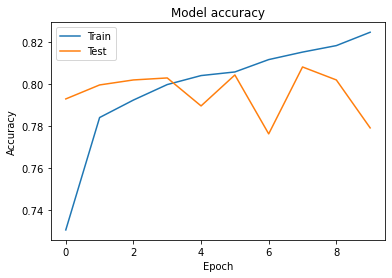

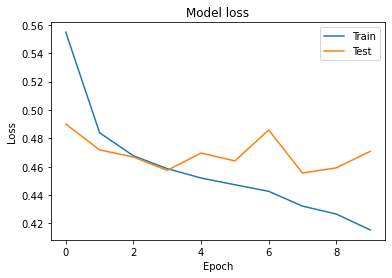

In [29]:
# Visualize the results:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()